<a href="https://colab.research.google.com/github/ciepielajan/GeoFabrik_Data_Extract/blob/main/GeoFabrik_extract_values.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import folium
import pandas as pd
from plotnine import *
!pip -q install geopandas
from geopandas import GeoDataFrame

%matplotlib inline

     |████████████████████████████████| 1.0MB 6.1MB/s 
     |████████████████████████████████| 14.8MB 253kB/s 
     |████████████████████████████████| 6.5MB 32.5MB/s 


In [2]:
link = "https://download.geofabrik.de/europe/poland/mazowieckie-latest-free.shp.zip"

In [3]:
!wget $link  -O map.shp.zip

--2021-04-07 05:53:27--  https://download.geofabrik.de/europe/poland/mazowieckie-latest-free.shp.zip
Resolving download.geofabrik.de (download.geofabrik.de)... 88.99.142.44, 116.202.112.212, 138.201.219.183
Connecting to download.geofabrik.de (download.geofabrik.de)|88.99.142.44|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 339787382 (324M) [application/zip]
Saving to: ‘map.shp.zip’

map.shp.zip         100%[===================>] 324.05M  24.7MB/s    in 14s     

2021-04-07 05:53:42 (23.4 MB/s) - ‘map.shp.zip’ saved [339787382/339787382]



In [4]:
!unzip -q map.shp.zip -d /content/maps

In [77]:
df = GeoDataFrame.from_file(f'maps/gis_osm_railways_free_1.shp', encoding='utf-8')

In [78]:
import re
warunek = df["fclass"].str.contains("subway", flags=re.IGNORECASE, regex=True, na=False) 

In [79]:
df = df[warunek]
df

,osm_id,code,fclass,name,layer,bridge,tunnel,geometry
33,5111165,6103,subway,Linia metra M1,-3,F,T,"LINESTRING (20.92881 52.29117, 20.92979 52.290..."
1296,173159217,6103,subway,Linia metra M2,-4,F,T,"LINESTRING (21.00176 52.23376, 21.00356 52.234..."
1915,220730440,6103,subway,None,0,F,F,"LINESTRING (21.05628 52.12553, 21.05702 52.125..."
1917,220730446,6103,subway,None,0,F,F,"LINESTRING (21.05596 52.12593, 21.05611 52.125..."
1918,220730447,6103,subway,None,0,F,F,"LINESTRING (21.05546 52.12622, 21.05569 52.12606)"
...,...,...,...,...,...,...,...,...
6340,725681123,6103,subway,Tory odstawcze przy stacji Kabaty,-3,F,T,"LINESTRING (21.06625 52.13094, 21.06612 52.13108)"
6341,725681124,6103,subway,Tory odstawcze przy stacji Kabaty,-3,F,T,"LINESTRING (21.06871 52.12831, 21.06784 52.129..."
6342,725681125,6103,subway,Tory odstawcze przy stacji Kabaty,-3,F,T,"LINESTRING (21.06625 52.13094, 21.06674 52.130..."
6730,894901651,6103,subway,Linia metra M2,-4,F,T,"LINESTRING (20.98203 52.22984, 20.98289 52.229..."


In [80]:
df.shape

(138, 8)

In [81]:
df['geometry'].loc[33].geom_type

'LineString'

In [22]:
#zamiana POLYGON  i LINESTRING na point żeby obliczyć najbardziej skrajne koordynaty
from shapely.geometry import Point

nodes = GeoDataFrame(columns=["geometry"])

for i in df.index.to_list():
  if df['geometry'].loc[i].geom_type=='Polygon':
    for j in df.loc[i]["geometry"].exterior.coords:
      nodes = nodes.append({'geometry': Point(j) },ignore_index=True)

  elif df['geometry'].loc[i].geom_type=='LineString':
    for j in df.loc[i]["geometry"].coords:
      nodes = nodes.append({'geometry': Point(j) },ignore_index=True)

  elif df['geometry'].loc[i].geom_type=='Point':
    nodes = nodes.append({'geometry': df['geometry'].loc[i] },ignore_index=True)

#podgląd losowego indexu
nodes.sample()

,geometry
1287,POINT (21.01466 52.21653)


In [75]:
m = folium.Map(location=[nodes["geometry"].y.mean() , nodes["geometry"].x.mean()], 
               tiles="cartodbpositron"
               )

folium.GeoJson(df).add_to(m)


x_min = nodes["geometry"].x.min()
x_max = nodes["geometry"].x.max()
y_min = nodes["geometry"].y.min()
y_max = nodes["geometry"].y.max()

# szukanie lewego górnego rogu i dolnego prawego
m.fit_bounds([[y_max , x_min], [y_min , x_max]]) 

m

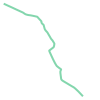

In [82]:
df["geometry"].loc[33]

In [29]:
m = folium.Map(location=[nodes["geometry"].y.mean() , nodes["geometry"].x.mean()], 
               tiles="cartodbpositron"
               )

folium.GeoJson(df).add_to(m)


x_min = nodes["geometry"].x.min()
x_max = nodes["geometry"].x.max()
y_min = nodes["geometry"].y.min()
y_max = nodes["geometry"].y.max()

# szukanie lewego górnego rogu i dolnego prawego
m.fit_bounds([[y_max , x_min], [y_min , x_max]]) 

m

In [101]:
stacje_metra = GeoDataFrame(columns=["geometry"])
for i in df['geometry'].loc[33].coords:
  stacje_metra = stacje_metra.append({'geometry': Point(i) },ignore_index=True)

In [ ]:
len(stacje_metra)

157

In [102]:
stacje_metra

,geometry
0,POINT (20.92881 52.29117)
1,POINT (20.92979 52.29072)
2,POINT (20.93612 52.28780)
3,POINT (20.93937 52.28633)
4,POINT (20.94369 52.28437)
...,...
152,POINT (21.05719 52.14028)
153,POINT (21.05787 52.13957)
154,POINT (21.06140 52.13585)
155,POINT (21.06276 52.13440)


In [104]:
stacje_metra.crs = "epsg:4326"  # nie wiem co to robi ale bez tego nie działało

In [105]:
m = folium.Map(location=[nodes["geometry"].y.mean() , nodes["geometry"].x.mean()], 
               tiles="cartodbpositron"
               )

folium.GeoJson(
    stacje_metra
    ).add_to(m)


x_min = nodes["geometry"].x.min()
x_max = nodes["geometry"].x.max()
y_min = nodes["geometry"].y.min()
y_max = nodes["geometry"].y.max()

# szukanie lewego górnego rogu i dolnego prawego
m.fit_bounds([[y_max , x_min], [y_min , x_max]]) 

m

In [33]:
df

,osm_id,code,fclass,name,layer,bridge,tunnel,geometry
33,5111165,6103,subway,Linia metra M1,-3,F,T,"LINESTRING (20.92881 52.29117, 20.92979 52.290..."
1296,173159217,6103,subway,Linia metra M2,-4,F,T,"LINESTRING (21.00176 52.23376, 21.00356 52.234..."
1915,220730440,6103,subway,None,0,F,F,"LINESTRING (21.05628 52.12553, 21.05702 52.125..."
1917,220730446,6103,subway,None,0,F,F,"LINESTRING (21.05596 52.12593, 21.05611 52.125..."
1918,220730447,6103,subway,None,0,F,F,"LINESTRING (21.05546 52.12622, 21.05569 52.12606)"
...,...,...,...,...,...,...,...,...
6340,725681123,6103,subway,Tory odstawcze przy stacji Kabaty,-3,F,T,"LINESTRING (21.06625 52.13094, 21.06612 52.13108)"
6341,725681124,6103,subway,Tory odstawcze przy stacji Kabaty,-3,F,T,"LINESTRING (21.06871 52.12831, 21.06784 52.129..."
6342,725681125,6103,subway,Tory odstawcze przy stacji Kabaty,-3,F,T,"LINESTRING (21.06625 52.13094, 21.06674 52.130..."
6730,894901651,6103,subway,Linia metra M2,-4,F,T,"LINESTRING (20.98203 52.22984, 20.98289 52.229..."


In [70]:
df[df.name == "Linia metra M2"]

,osm_id,code,fclass,name,layer,bridge,tunnel,geometry


In [69]:
df.loc["5563"]

KeyError: ignored

In [38]:
m = folium.Map(location=[nodes["geometry"].y.mean() , nodes["geometry"].x.mean()], 
               tiles="cartodbpositron"
               )

folium.GeoJson(
    df[df.name == "Linia metra M2"]
).add_to(m)


x_min = nodes["geometry"].x.min()
x_max = nodes["geometry"].x.max()
y_min = nodes["geometry"].y.min()
y_max = nodes["geometry"].y.max()

# szukanie lewego górnego rogu i dolnego prawego
m.fit_bounds([[y_max , x_min], [y_min , x_max]]) 

m

In [63]:
m = folium.Map(location=[nodes["geometry"].y.mean() , nodes["geometry"].x.mean()], 
               tiles="cartodbpositron"
               )

folium.GeoJson(
    df[df.name == "Linia metra M2"].loc[[5560, 5561, 5562, 5563]]
).add_to(m)


x_min = nodes["geometry"].x.min()
x_max = nodes["geometry"].x.max()
y_min = nodes["geometry"].y.min()
y_max = nodes["geometry"].y.max()

# szukanie lewego górnego rogu i dolnego prawego
m.fit_bounds([[y_max , x_min], [y_min , x_max]]) 

m

KeyError: ignored

In [46]:
df = GeoDataFrame.from_file(f'maps/gis_osm_transport_free_1.shp', encoding='utf-8')
df

,osm_id,code,fclass,name,geometry
0,26405535,5621,bus_stop,Lamina 03,POINT (21.02257 52.08243)
1,29886621,5621,bus_stop,Wola Pasikońska 02,POINT (20.38094 52.26599)
2,29886652,5621,bus_stop,Żelazowa Wola 02,POINT (20.30745 52.25894)
3,31156649,5621,bus_stop,PKP Koło 05,POINT (20.95753 52.24665)
4,31156960,5621,bus_stop,Górki 02,POINT (21.22077 52.10887)
...,...,...,...,...,...
13787,8578746714,5621,bus_stop,Mińsk Mazowiecki Dworzec Autobusowy,POINT (21.55489 52.17616)
13788,8578875467,5621,bus_stop,Nieczatów,POINT (21.05217 51.43747)
13789,8582702755,5621,bus_stop,Augustówka Kolejowa,POINT (21.49284 51.98581)
13790,8582705685,5621,bus_stop,Augustówka Kołbielska,POINT (21.48445 51.98348)


In [48]:
df.fclass.value_counts()

bus_stop           12582
tram_stop            592
railway_halt         235
railway_station      144
taxi                 127
bus_station           47
helipad               36
ferry_terminal        23
airport                5
airfield               1
Name: fclass, dtype: int64

In [ ]:
df[df.name == "Linia metra M2"]

In [53]:
warunek = df["name"].str.contains("metro", flags=re.IGNORECASE, regex=True, na=False) 
df[warunek]

,osm_id,code,fclass,name,geometry
12,32597790,5621,bus_stop,Metro Ratusz Arsenał 06,POINT (21.00215 52.24486)
85,247488490,5603,tram_stop,Metro Pole Mokotowskie 03,POINT (21.00783 52.20833)
86,247488491,5603,tram_stop,Metro Pole Mokotowskie 04,POINT (21.00762 52.20905)
92,248059657,5603,tram_stop,Metro Ratusz Arsenał 04,POINT (21.00075 52.24500)
116,249327910,5603,tram_stop,Metro Wierzbno 04,POINT (21.01818 52.18913)
...,...,...,...,...,...
12063,7179728405,5621,bus_stop,Metro Wawrzyszew 01,POINT (20.93700 52.28719)
12221,7371526542,5621,bus_stop,Metro Młynów 05,POINT (20.96013 52.23754)
12222,7371526543,5621,bus_stop,Metro Młynów 06,POINT (20.96045 52.23780)
12223,7371526547,5621,bus_stop,Metro Księcia Janusza 04,POINT (20.94294 52.23885)


In [55]:
df[warunek].fclass.value_counts()

bus_stop       148
tram_stop       34
bus_station      2
Name: fclass, dtype: int64

In [58]:
df[warunek & (df.fclass == "bus_station")]

,osm_id,code,fclass,name,geometry
2668,1700789144,5622,bus_station,Metro Młociny,POINT (20.92789 52.29110)
4762,2482753234,5622,bus_station,Metro Trocka,POINT (21.05265 52.27654)


In [59]:
m = folium.Map(location=[nodes["geometry"].y.mean() , nodes["geometry"].x.mean()], 
               tiles="cartodbpositron"
               )

folium.GeoJson(
    df[warunek & (df.fclass == "bus_station")]
).add_to(m)


x_min = nodes["geometry"].x.min()
x_max = nodes["geometry"].x.max()
y_min = nodes["geometry"].y.min()
y_max = nodes["geometry"].y.max()

# szukanie lewego górnego rogu i dolnego prawego
m.fit_bounds([[y_max , x_min], [y_min , x_max]]) 

m